In [2]:
# implementation of probabilistic matrix factorisation

%load_ext autoreload
%autoreload 2

from utils import *

import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from tqdm.notebook import tqdm
from itertools import chain
from collections import Counter, defaultdict
from pathlib import Path
from sklearn import metrics
import csv
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [4]:
movieid_mid_lookup = get_movieid_mid_lookup(recompute=False)

In [5]:
user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
user_val_Xs, movie_val_Xs, val_ys = get_dataset(val_set, include_ys=True, recompute=False)
movie_genres_one_hot = get_movie_genres_one_hot(recompute=False)
train_genres = get_dataset_genres(train_set, recompute=False)
val_genres = get_dataset_genres(val_set, recompute=False)

retrieving dataset from dataset/train_ratings_binary.csv
retrieving dataset from dataset/val_ratings_binary.csv


no_genre_count = 0
total = 0

with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        if movieid_mid_lookup[int(float(rating["movieId"]))] not in movie_genres_one_hot:
            no_genre_count += 1
        total += 1

print(f"{no_genre_count}/{total} entries in the test data doesn't have genre info ({no_genre_count/total}%)")
# all movies in test data accounted for in genre information dataset

In [5]:
# # no memory - implicitly calculating user movie matrix from now on

# movie_embeddings = tf.Variable(tf.random_normal([5, NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_embeddings = tf.Variable(tf.random_normal([NUM_USERS, 5], stddev=0.03, dtype=tf.float32))
# movie_bias = tf.Variable(tf.random_normal([1, NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_bias = tf.Variable(tf.random_normal([NUM_USERS, 1], stddev=0.03, dtype=tf.float32))

# user_movie_score = tf.tensordot(user_embeddings, movie_embeddings, axes = 1)+.14*tf.tile(movie_bias, [NUM_USERS, 1]) +.87*tf.tile(user_bias, [1, NUM_MOVIES])


In [7]:
# the model

embedding_dim = 40
assert embedding_dim > 20

movie_genre_embeddings = tf.placeholder(dtype=tf.float32, shape=[None, 20])
movie_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer()([NUM_MOVIES, embedding_dim]))
user_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer()([NUM_USERS, embedding_dim]))
movie_bias = tf.Variable(tf.random_normal([NUM_MOVIES], stddev=0.03, dtype=tf.float32))
user_bias = tf.Variable(tf.random_normal([NUM_USERS], stddev=0.03, dtype=tf.float32))

user_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
movie_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
user_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
movie_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

user_embedding_columns = tf.reshape(tf.gather_nd(user_embeddings, user_slice_idxs), [-1, embedding_dim])
movie_embedding_rows = tf.reshape(tf.gather_nd(movie_embeddings, movie_slice_idxs), [-1, embedding_dim])
print("movie_embedding_rows shape", movie_embedding_rows.shape)

user_slice_bias = tf.reshape(tf.gather_nd(user_bias, user_slice_idxs), [-1, 1])
movie_slice_bias = tf.reshape(tf.gather_nd(movie_bias, movie_slice_idxs), [-1, 1])
# print("user_slice_bias shape", user_slice_bias.shape)

# print((user_embedding_columns * tf.concat((movie_embedding_rows, movie_genre_embeddings), axis=1)).shape)
# print(movie_slice_bias.shape)
# print(user_slice_bias".shape)

mult_input = movie_embedding_rows * user_embedding_columns
input_layer = tf.concat((
    mult_input,
    movie_embedding_rows,
    movie_genre_embeddings,
    user_embedding_columns,
    user_slice_bias,
    movie_slice_bias), axis=1)
print(movie_embedding_rows.shape, user_embedding_columns.shape, user_slice_bias.shape)
print("input layer shape", input_layer.shape)

W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[embedding_dim*3+2+20, 40], dtype=tf.float32))
b1 = tf.Variable(initial_value=np.zeros(shape=[40], dtype=np.float32))
l1 = tf.nn.relu(tf.matmul(input_layer, W1) + b1)

W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[40, 20], dtype=tf.float32))
b2 = tf.Variable(initial_value=np.zeros(shape=[20], dtype=np.float32))
l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)

W3 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[20, 2], dtype=tf.float32))
b3 = tf.Variable(initial_value=np.zeros(shape=[2], dtype=np.float32))
pred_y =tf.nn.sigmoid(tf.matmul(l2, W3) + b3)

print("pred_y shape", pred_y.shape)

# embedding_pred_vectors = tf.reshape(tf.reduce_sum(user_embedding_columns * tf.concat((movie_embedding_rows, movie_genre_embeddings), axis=1), axis=1), (-1, 1))
# pred_y = embedding_pred_vectors + .14*movie_slice_bias + .87*user_slice_bias
# print(embedding_pred_vectors.shape)
# print(pred_y.shape)

y_true = tf.placeholder(dtype=tf.float32, shape=[None, 2])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

movie_embedding_rows shape (?, 40)
(?, 40) (?, 40) (?, 1)
input layer shape (?, 142)
pred_y shape (?, 2)


In [9]:
plot_weights = True

def run_expr(learning_rate=.05, epochs=60):
#     l2_loss_term = .0001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
    mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
    ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
    loss = mse_loss_term
    # + l2_loss_term
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    init = tf.global_variables_initializer()

    flat_val_ys = [(1 if y[0] > y[1] else 0) for y in val_ys]

    min_acc_auc = (math.inf, math.inf)
    
    with tf.Session() as sess:
        sess.run(init)

        for epoch in tqdm(range(epochs), leave=False):
            feed_dict = {user_slice_idxs: user_Xs, 
                         movie_slice_idxs: movie_Xs, 
                         movie_genre_embeddings: train_genres,
                         y_true: ys}
            print("training")
            outs = (train_step, loss, pred_y[:5], mse_loss_term)
            _, lossval, pred_y_val, mse_loss_term_val = sess.run(outs, feed_dict=feed_dict)
            print("train loss", lossval, "pred_ys", pred_y_val, "true_ys", ys[:5])

            feed_dict = {user_slice_idxs: user_val_Xs, 
                             movie_slice_idxs: movie_val_Xs,
                             movie_genre_embeddings: val_genres,
                             y_true: val_ys}
            val_y_pred, val_loss_val = sess.run((pred_y, loss), feed_dict=feed_dict)
            flat_pred_y_floats = [y[0]/(y[0]+y[1]) for y in val_y_pred]
            flat_pred_y_bools = [(1 if y[0] > y[1] else 0) for y in val_y_pred]
            
            print("val loss", val_loss_val)
            acc = metrics.accuracy_score(flat_val_ys, flat_pred_y_bools)
            fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)
            auc = metrics.auc(fpr, tpr)
            min_acc_auc = min(min_acc_auc, (acc, auc))
        if plot_weights:
            print("plotting")
#                 plt.hist(sess.run(mult_input, feed_dict))
            mult_inputs = sess.run(mult_input, feed_dict), 

            pred_ys = sess.run(pred_y, feed_dict)

            mult_input_pos = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] > pred[1]]).flatten()
            if len(mult_input_pos) > 0:
                print("avg pos", sum(mult_input_pos)/len(mult_input_pos), "pos ct", len(mult_input_pos))
            else:
                print(mult_input_pos)
            mult_input_neg = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] <= pred[1]]).flatten()
            if len(mult_input_neg) > 0:
                print("avg neg", sum(mult_input_neg)/len(mult_input_neg), "neg ct", len(mult_input_neg))
            else:
                print("mult_input_neg", mult_input_neg)
            
            plt.title("pos inputs")
            plt.hist(mult_input_pos)
            plt.show()
            plt.title("neg inputs")
            plt.hist(mult_input_neg)
            plt.show()
            
    return min_acc_auc

In [67]:
min_overall_score = (math.inf, math.inf)
experiment_scores = {}
# experiments = zip([.1, .07, .06, .05, .04, .03, .01], [40] * 100)
experiments = zip([.04], [40] * 100)

for lr, epochs in tqdm(list(experiments)):
    try:
        score = run_expr(lr, epochs)
        min_overall_score = min(min_overall_score, score)
        experiment_scores[lr] = score
    except Exception as e:
        print(e)
        pass

print(min_overall_score)
print(experiment_scores)


training
train loss 0.2515739 pred_ys [[0.4623581  0.4693478 ]
 [0.53988504 0.53399694]
 [0.47324896 0.49743822]
 [0.54168123 0.5514234 ]
 [0.5124715  0.5423559 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.2486172
training
train loss 0.2475672 pred_ys [[0.4989538  0.49962556]
 [0.5152831  0.4390095 ]
 [0.5288711  0.48330185]
 [0.46916476 0.4717171 ]
 [0.4493824  0.4697291 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.23959264
training
train loss 0.23631155 pred_ys [[0.44698083 0.55141795]
 [0.5969238  0.42021775]
 [0.5783154  0.4891485 ]
 [0.41313457 0.59883255]
 [0.41751164 0.6039995 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.22197798
training
train loss 0.21472377 pred_ys [[0.3508643  0.6059679 ]
 [0.7229115  0.31664622]
 [0.5916914  0.45385188]
 [0.28494906 0.7007574 ]
 [0.29347023 0.7164011 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.20815589
training
train loss 0.19955584 pred_ys [[0.270616   0.6620174 ]
 [0.90111697 0.1473682 

KeyboardInterrupt: 

epoch 0
training
train loss 0.25182512 pred_ys [[0.501613   0.5334394 ]
 [0.4916665  0.5609421 ]
 [0.44099402 0.5146452 ]
 [0.45465174 0.5125157 ]
 [0.46772286 0.54812884]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.24836594
val acc 0.5489360967944877 val auc 0.5861117398922154
epoch 1
training
train loss 0.2458226 pred_ys [[0.4812835  0.5092064 ]
 [0.5474965  0.40978247]
 [0.5585039  0.38583666]
 [0.5032277  0.4971644 ]
 [0.5101655  0.48697487]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.23378897
val acc 0.6215632185747477 val auc 0.6612391407054783
epoch 2
training
train loss 0.22700189 pred_ys [[0.43441767 0.62447625]
 [0.6231866  0.3617071 ]
 [0.63431156 0.36974764]
 [0.41675472 0.6180899 ]
 [0.44648957 0.6232858 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.21670574
val acc 0.6662435025089792 val auc 0.7158944808006056
epoch 3
training
train loss 0.20941393 pred_ys [[0.3254245  0.73498034]
 [0.8270504  0.18054333]
 [0.6699146  0.3454054 ]
 [0.26

val loss 0.18685597
val acc 0.7168946768832847 val auc 0.7927895855471271
epoch 29
training
train loss 0.16403744 pred_ys [[0.20824996 0.80545855]
 [0.931177   0.08298314]
 [0.393748   0.60872984]
 [0.02338055 0.9815848 ]
 [0.03045669 0.97701013]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.18659782
val acc 0.7170892140398816 val auc 0.7928859834882278
epoch 30
training
train loss 0.16302897 pred_ys [[0.21303251 0.8043734 ]
 [0.9267198  0.0871678 ]
 [0.39759907 0.6071582 ]
 [0.02443019 0.9812174 ]
 [0.03264758 0.9763659 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.18639691
val acc 0.7174177767953679 val auc 0.7933223452907323
epoch 31
training
train loss 0.16187595 pred_ys [[0.21711162 0.8017523 ]
 [0.9240131  0.08498007]
 [0.39841256 0.60594696]
 [0.02392954 0.9814566 ]
 [0.03314042 0.9763824 ]] true_ys [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
val loss 0.18630967
val acc 0.7182859426150394 val auc 0.7943050836590848
epoch 32
training
train loss 0.1604752 pred_ys [[0

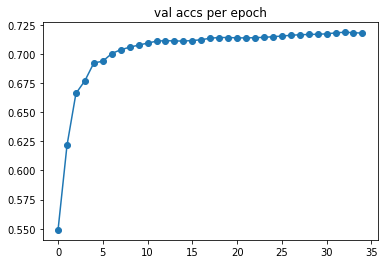

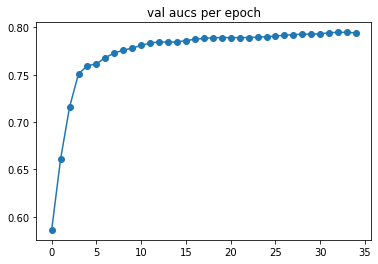

In [10]:
sess = tf.Session() # we don't want to close the session

learning_rate=.05
epochs=35
#     l2_loss_term = .0001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
loss = mse_loss_term
# + l2_loss_term
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

flat_val_ys = [(1 if y[0] > y[1] else 0) for y in val_ys]

min_acc_auc = (math.inf, math.inf)

sess.run(init)

val_accs = []
val_aucs = []

for epoch in tqdm(range(epochs), leave=False):
    print("epoch", epoch)
    feed_dict = {user_slice_idxs: user_Xs, 
                 movie_slice_idxs: movie_Xs, 
                 movie_genre_embeddings: train_genres,
                 y_true: ys}
    print("training")
    outs = (train_step, loss, pred_y[:5], mse_loss_term)
    _, lossval, pred_y_val, mse_loss_term_val = sess.run(outs, feed_dict=feed_dict)
    print("train loss", lossval, "pred_ys", pred_y_val, "true_ys", ys[:5])

    feed_dict = {user_slice_idxs: user_val_Xs, 
                     movie_slice_idxs: movie_val_Xs,
                     movie_genre_embeddings: val_genres,
                     y_true: val_ys}
    val_y_pred, val_loss_val = sess.run((pred_y, loss), feed_dict=feed_dict)
    flat_pred_y_floats = [y[0]/(y[0]+y[1]) for y in val_y_pred]
    flat_pred_y_bools = [(1 if y[0] > y[1] else 0) for y in val_y_pred]

    print("val loss", val_loss_val)
    acc = metrics.accuracy_score(flat_val_ys, flat_pred_y_bools)
    fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)
    auc = metrics.auc(fpr, tpr)
    print("val acc", acc, "val auc", auc)
    min_acc_auc = min(min_acc_auc, (acc, auc))
    val_accs.append(acc)
    val_aucs.append(auc)

plt.title("val accs per epoch")
plt.plot(val_accs, marker='o')
plt.show()

plt.title("val aucs per epoch")
plt.plot(val_aucs, marker='o')
plt.show()


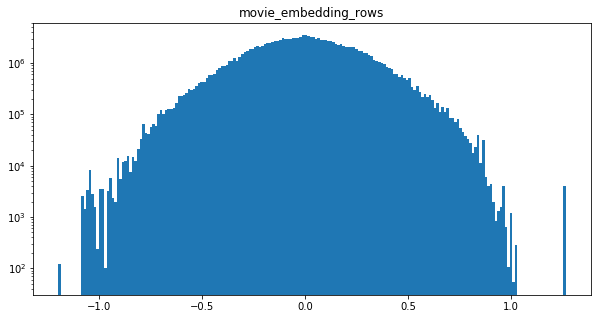

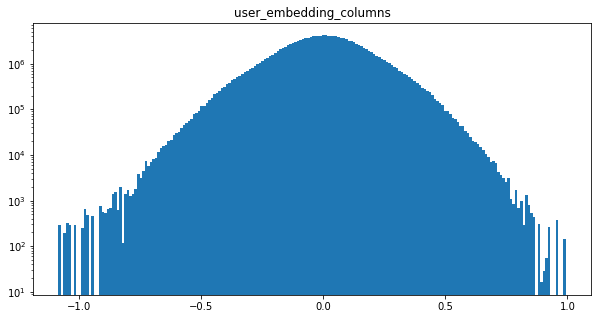

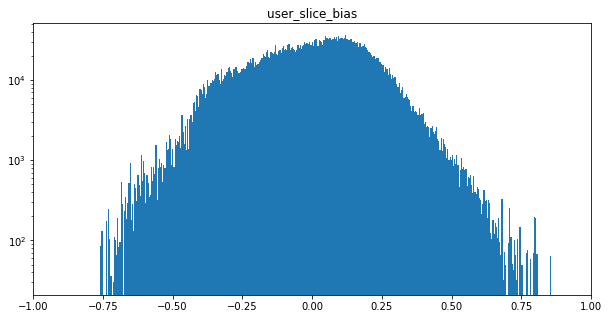

In [94]:
plt.rc('figure', figsize=(10, 5))
plt.title("movie_embedding_rows")
plt.hist(sess.run(movie_embedding_rows, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_embedding_columns")
plt.hist(sess.run(user_embedding_columns, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_slice_bias")
plt.hist(sess.run(user_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.xlim((-1, 1))
plt.show()
# movie embedding and user embedding look like textbook normal distributions makes sense yepp
# user biases look like some sort of bimodal distribution?????
# and why are movie slice biases so chaotic

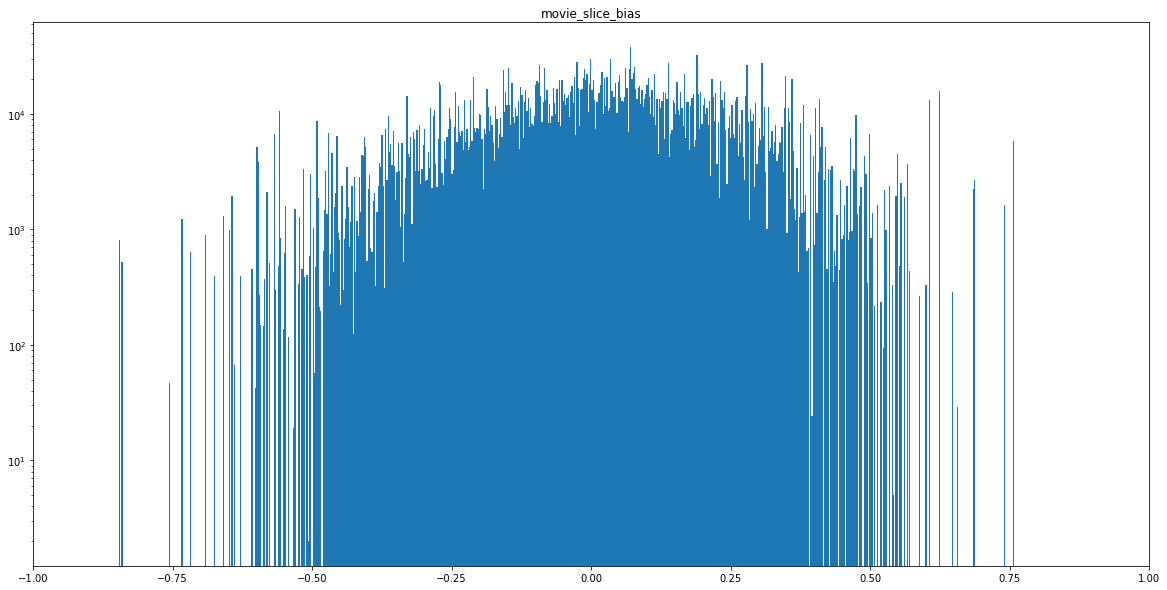

In [93]:
plt.title("movie_slice_bias")
plt.rc('figure', figsize=(20, 10))
plt.hist(sess.run(movie_slice_bias, feed_dict).flatten(), log=True, bins=800)
plt.xlim((-1, 1))
plt.show()

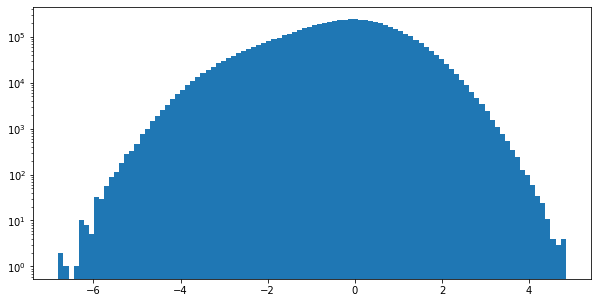

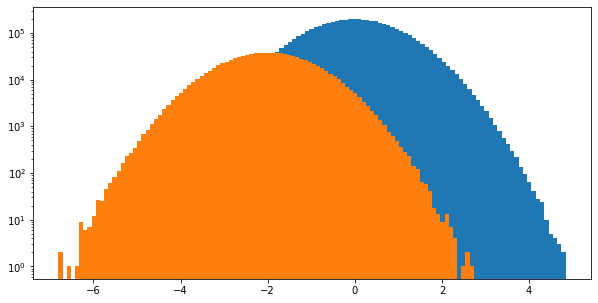

In [136]:
mode1 = np.random.normal(0, 1, 5000000)
mode2 = np.random.normal(-2, 1, 1000000)

plt.hist(np.concatenate((mode1, mode2)), bins=100, log=True)
plt.show()
plt.hist(mode1, bins=100, log=True)
plt.hist(mode2, bins=100, log=True)
plt.show()


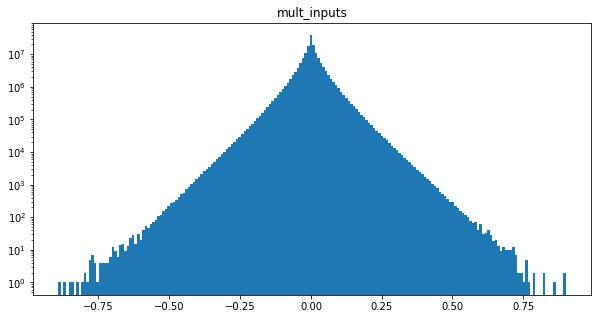

avg pos -0.00035934525807793615 pos ct 75741520
avg neg 0.0005471634820769635 neg ct 84227920


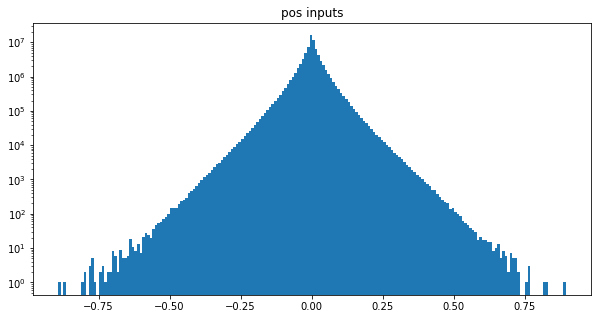

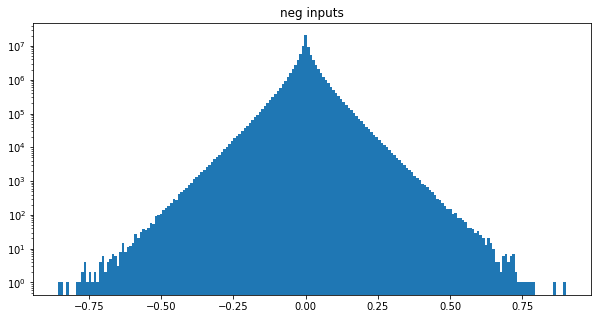

In [127]:
mult_inputs = sess.run(mult_input, feed_dict)
plt.cla()
plt.title("mult_inputs")
plt.hist(mult_inputs.flatten(), log=True, bins=200)
plt.show()

pred_ys = sess.run(pred_y, feed_dict)

mult_input_pos = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] > pred[1]]).flatten()
if len(mult_input_pos) > 0:
    print("avg pos", sum(mult_input_pos)/len(mult_input_pos), "pos ct", len(mult_input_pos))
else:
    print("mult_input_pos", mult_input_pos)

mult_input_neg = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] <= pred[1]]).flatten()
if len(mult_input_neg) > 0:
    print("avg neg", sum(mult_input_neg)/len(mult_input_neg), "neg ct", len(mult_input_neg))
else:
    print("mult_input_neg", mult_input_neg)

plt.title("pos inputs")
plt.hist(mult_input_pos, bins=200, log=True)
plt.show()
plt.title("neg inputs")
plt.hist(mult_input_neg, bins=200, log=True)
plt.show()

# makes sense why these are basically chi square - composed of normal distributions multiplied together which is fundamentally what we're predicting